# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

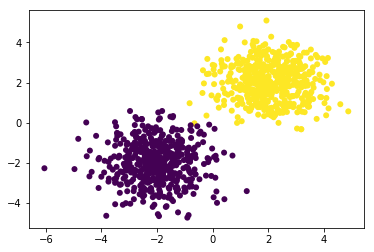

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [23]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [24]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [26]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [48]:
X.shape, Y.shape

((1000, 2), (1000, 2))

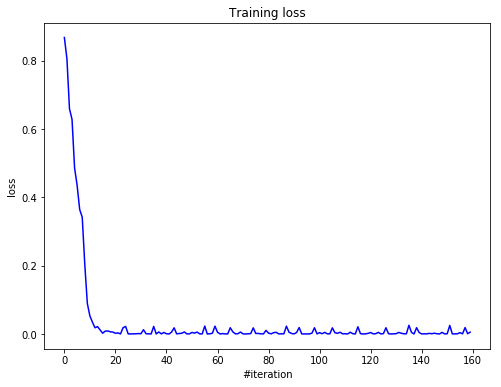

Current loss: 0.005368


In [27]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [10]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [22]:
################################################
y_train_encoded = np.eye(10)[y_train]
y_test_encoded = np.eye(10)[y_test]
y_val_encoded = np.eye(10)[y_val]
################################################


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [55]:
################################################
def train(X, Y, net, criterion, optimizer, optimizer_config, n_epoch=100, batch_size=500, visualize=True):
    loss_history = []
    optimizer_state = {}

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), 
                      net.getGradParameters(), 
                      optimizer_config,
                      optimizer_state)      

        loss_history.append(loss)
        if visualize:
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("Training loss")
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b')
            plt.show()

            print('Current loss: %f' % loss)    
    return loss_history


In [89]:
def plot(loss_history_dict):
    plt.figure(figsize=(8, 6))
    
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for nnet_name, loss_history in loss_history_dict.items():
        plt.plot(loss_history, label=nnet_name)
    plt.legend()
    plt.show()
    
    for nnet_name, loss_history in loss_history_dict.items():
        print('Final %s loss: %f' % (nnet_name, loss_history[-1]))  

In [73]:
shape_0 = X_train.reshape((X_train.shape[0], -1)).shape[1]

net = Sequential()
net.add(Linear(shape_0, 200))
net.add(ReLU())
net.add(Linear(200, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

optimizer = sgd_momentum

n_epoch = 50
batch_size = 128

print(net)

Linear 784 -> 200
ReLU
Linear 200 -> 50
ReLU
Linear 50 -> 10
LogSoftMax



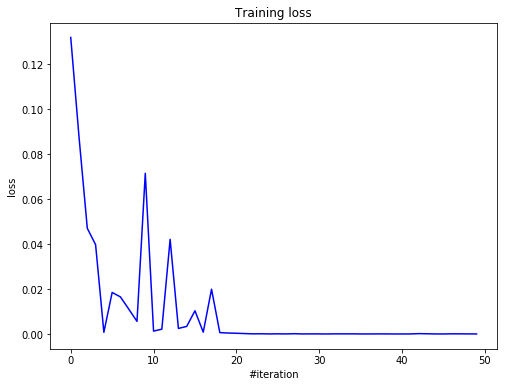

Current loss: 0.000010
CPU times: user 2min 47s, sys: 5.76 s, total: 2min 52s
Wall time: 2min 13s


In [74]:
%%time
loss_history = train(
    X=X_train.reshape((X_train.shape[0], -1)), 
    Y=y_train_encoded, 
    net=net, 
    criterion=criterion, 
    optimizer=optimizer, 
    optimizer_config=optimizer_config, 
    n_epoch=n_epoch, 
    batch_size=batch_size)



In [81]:
loss_history_dict = {}
loss_history_dict["ReLU nnet"] = loss_history.copy()


In [85]:
shape_0 = X_train.reshape((X_train.shape[0], -1)).shape[1]

net = Sequential()
net.add(Linear(shape_0, 200))
net.add(ELU(alpha=0.1))
net.add(Linear(200, 50))
net.add(ELU(alpha=0.1))
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

optimizer = sgd_momentum

n_epoch = 50
batch_size = 128

print(net)

Linear 784 -> 200
ELU
Linear 200 -> 50
ELU
Linear 50 -> 10
LogSoftMax



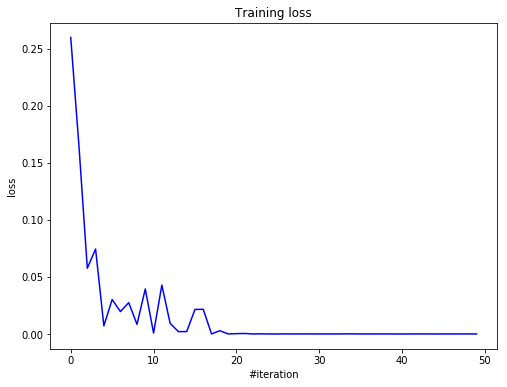

Current loss: 0.000004
CPU times: user 3min 7s, sys: 6.52 s, total: 3min 13s
Wall time: 2min 29s


In [86]:
%%time
loss_history = train(
    X=X_train.reshape((X_train.shape[0], -1)), 
    Y=y_train_encoded, 
    net=net, 
    criterion=criterion, 
    optimizer=optimizer, 
    optimizer_config=optimizer_config, 
    n_epoch=n_epoch, 
    batch_size=batch_size)



In [87]:
loss_history_dict["ELU nnet"] = loss_history.copy()


In [91]:
shape_0 = X_train.reshape((X_train.shape[0], -1)).shape[1]

net = Sequential()
net.add(Linear(shape_0, 200))
net.add(LeakyReLU(slope=0.05))
net.add(Linear(200, 50))
net.add(LeakyReLU(slope=0.05))
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

optimizer = sgd_momentum

n_epoch = 50
batch_size = 128

print(net)

Linear 784 -> 200
LeakyReLU
Linear 200 -> 50
LeakyReLU
Linear 50 -> 10
LogSoftMax



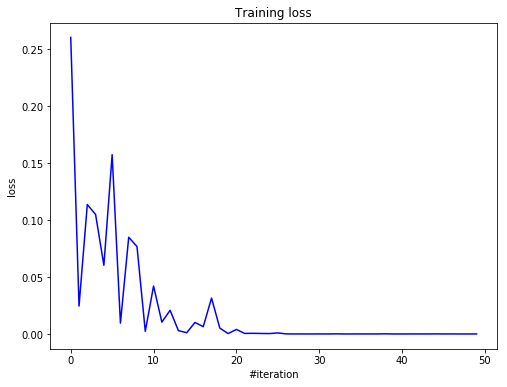

Current loss: 0.000009
CPU times: user 2min 46s, sys: 5.7 s, total: 2min 52s
Wall time: 2min 13s


In [92]:
%%time
loss_history = train(
    X=X_train.reshape((X_train.shape[0], -1)), 
    Y=y_train_encoded, 
    net=net, 
    criterion=criterion, 
    optimizer=optimizer, 
    optimizer_config=optimizer_config, 
    n_epoch=n_epoch, 
    batch_size=batch_size)




In [93]:
loss_history_dict["LeakyReLU nnet"] = loss_history.copy()


In [101]:
shape_0 = X_train.reshape((X_train.shape[0], -1)).shape[1]

net = Sequential()
net.add(Linear(shape_0, 200))
net.add(SoftPlus())
net.add(Linear(200, 50))
net.add(SoftPlus())
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

optimizer = sgd_momentum

n_epoch = 50
batch_size = 128

print(net)

Linear 784 -> 200
SoftPlus
Linear 200 -> 50
SoftPlus
Linear 50 -> 10
LogSoftMax



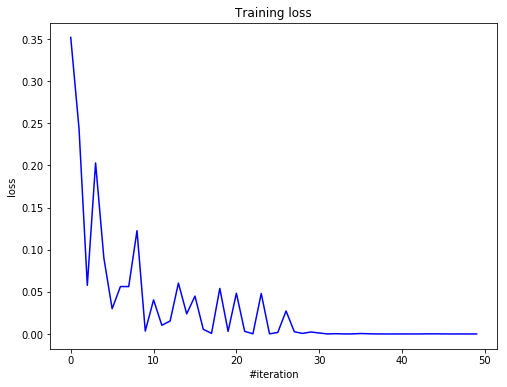

Current loss: 0.000002
CPU times: user 2min 55s, sys: 5.48 s, total: 3min
Wall time: 2min 20s


In [102]:
%%time
loss_history = train(
    X=X_train.reshape((X_train.shape[0], -1)), 
    Y=y_train_encoded, 
    net=net, 
    criterion=criterion, 
    optimizer=optimizer, 
    optimizer_config=optimizer_config, 
    n_epoch=n_epoch, 
    batch_size=batch_size)




In [103]:
loss_history_dict["SoftPlus nnet"] = loss_history.copy()


Я взяла одинаковые сетки с различными активационными функциями, из графика ниже можно увидеть, что меньше всего разносит сетки с ReLU и ELU, но несмотря на то, что SoftPlus nnet сходится медленнее остальных, минимум logloss именно у неё.

По времени разницы на таком масштабе сетки неразличимы. 

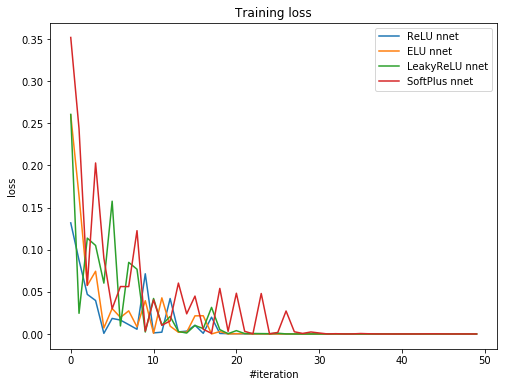

Final ReLU nnet loss: 0.000010
Final ELU nnet loss: 0.000004
Final LeakyReLU nnet loss: 0.000009
Final SoftPlus nnet loss: 0.000002


In [104]:
plot(loss_history_dict)

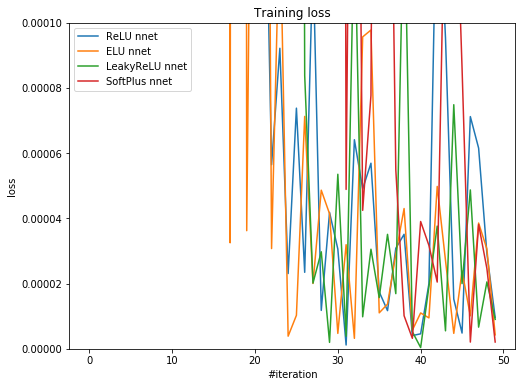

Final ReLU nnet loss: 0.000010
Final ELU nnet loss: 0.000004
Final LeakyReLU nnet loss: 0.000009
Final SoftPlus nnet loss: 0.000002


In [105]:
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylim(top=0.0001)
plt.ylabel("loss")
for nnet_name, loss_history in loss_history_dict.items():
    plt.plot(loss_history, label=nnet_name)
plt.legend()
plt.show()

for nnet_name, loss_history in loss_history_dict.items():
    print('Final %s loss: %f' % (nnet_name, loss_history[-1]))  

Возьмём сетку с SoftPlus и попробуем регуляризовать с помощью BatchNormalization

In [110]:
shape_0 = X_train.reshape((X_train.shape[0], -1)).shape[1]

net = Sequential()
net.add(Linear(shape_0, 200))
net.add(BatchNormalization(alpha=0.8))
net.add(ChannelwiseScaling(200))
net.add(SoftPlus())
net.add(Linear(200, 50))
net.add(BatchNormalization(alpha=0.8))
net.add(ChannelwiseScaling(50))
net.add(SoftPlus())
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

optimizer = sgd_momentum

n_epoch = 50
batch_size = 128

print(net)


Linear 784 -> 200
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 200 -> 50
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 50 -> 10
LogSoftMax



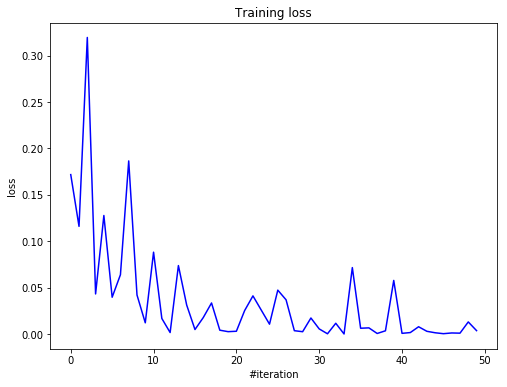

Current loss: 0.003668
CPU times: user 3min 29s, sys: 6.47 s, total: 3min 35s
Wall time: 2min 55s


In [111]:
%%time
loss_history = train(
    X=X_train.reshape((X_train.shape[0], -1)), 
    Y=y_train_encoded, 
    net=net, 
    criterion=criterion, 
    optimizer=optimizer, 
    optimizer_config=optimizer_config, 
    n_epoch=n_epoch, 
    batch_size=batch_size)




In [112]:
loss_history_dict["SoftPlus+BatchNormalization  nnet"] = loss_history.copy()


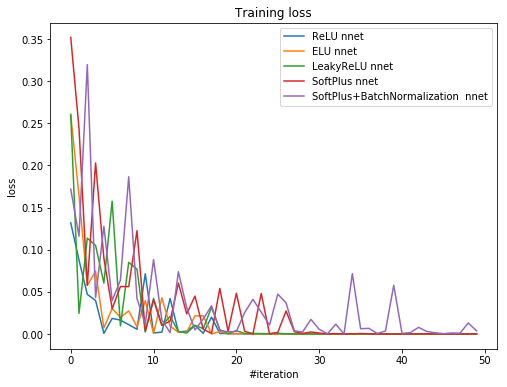

Final ReLU nnet loss: 0.000010
Final ELU nnet loss: 0.000004
Final LeakyReLU nnet loss: 0.000009
Final SoftPlus nnet loss: 0.000002
Final SoftPlus+BatchNormalization  nnet loss: 0.003668


In [113]:
plot(loss_history_dict)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

После добавления BatchNormalization перед активациями, сетка начала медленнее учиться(скорее всего из-за того, что увеличилось количество параметров). Попробуем использовать другой оптимизатор

In [ ]:
################################################

In [114]:
shape_0 = X_train.reshape((X_train.shape[0], -1)).shape[1]

net = Sequential()
net.add(Linear(shape_0, 200))
net.add(BatchNormalization(alpha=0.8))
net.add(ChannelwiseScaling(200))
net.add(SoftPlus())
net.add(Linear(200, 50))
net.add(BatchNormalization(alpha=0.8))
net.add(ChannelwiseScaling(50))
net.add(SoftPlus())
net.add(Linear(50, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}

optimizer = adam_optimizer

n_epoch = 50
batch_size = 128

print(net)


Linear 784 -> 200
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 200 -> 50
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 50 -> 10
LogSoftMax



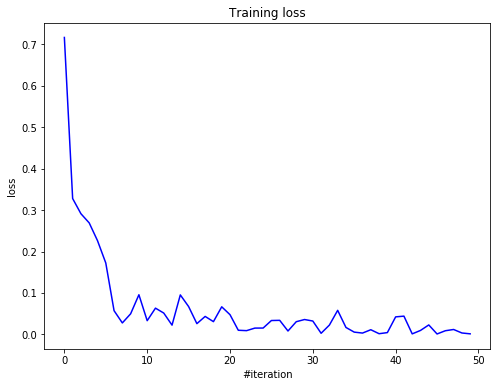

Current loss: 0.001185
CPU times: user 3min 54s, sys: 6.64 s, total: 4min 1s
Wall time: 3min 22s


In [115]:
%%time
loss_history = train(
    X=X_train.reshape((X_train.shape[0], -1)), 
    Y=y_train_encoded, 
    net=net, 
    criterion=criterion, 
    optimizer=optimizer, 
    optimizer_config=optimizer_config, 
    n_epoch=n_epoch, 
    batch_size=batch_size)



In [116]:
loss_history_dict["SoftPlus+BatchNormalization nnet + adam"] = loss_history.copy()


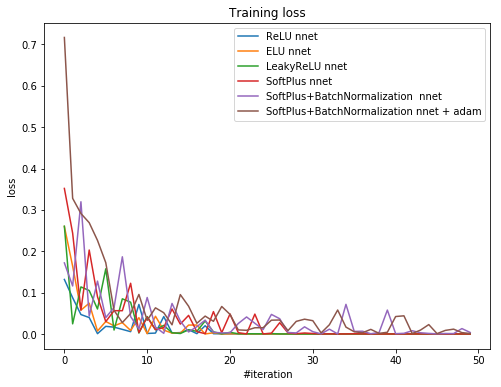

Final ReLU nnet loss: 0.000010
Final ELU nnet loss: 0.000004
Final LeakyReLU nnet loss: 0.000009
Final SoftPlus nnet loss: 0.000002
Final SoftPlus+BatchNormalization  nnet loss: 0.003668
Final SoftPlus+BatchNormalization nnet + adam loss: 0.001185


In [117]:
plot(loss_history_dict)

Изменение оптимизатора позволило немного уменьшить итоговый лосс

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [127]:
################################################
# посчитаем скор последней модели

test_prediction = net.forward(X_test.reshape((X_test.shape[0], -1)))

In [125]:
np.round(np.exp(test_prediction))

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [126]:
from sklearn.metrics import accuracy_score

accuracy_score(np.round(np.exp(test_prediction)), y_test_encoded)

0.97709999999999997

In [129]:
res_onehot = np.round(np.exp(test_prediction))


Посмотрим на ответы на первых десяти картинках из теста

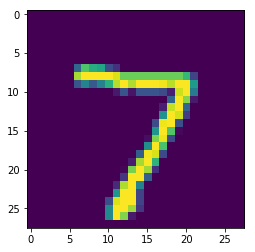

Предсказано: 7, ответ: 7


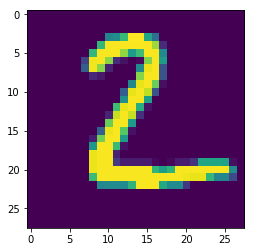

Предсказано: 2, ответ: 2


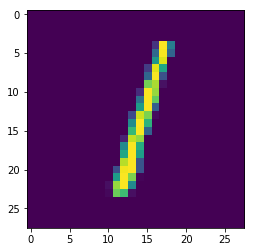

Предсказано: 1, ответ: 1


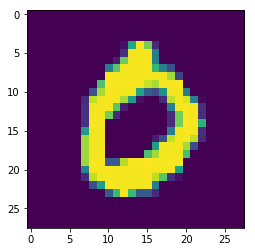

Предсказано: 0, ответ: 0


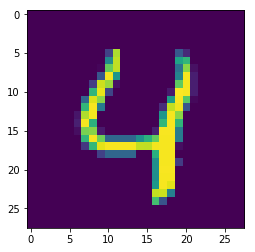

Предсказано: 4, ответ: 4


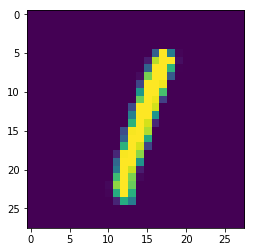

Предсказано: 1, ответ: 1


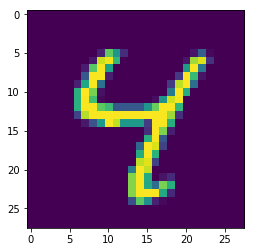

Предсказано: 4, ответ: 4


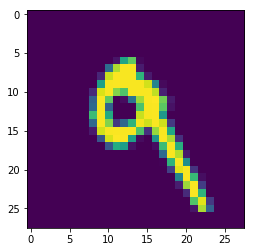

Предсказано: 9, ответ: 9


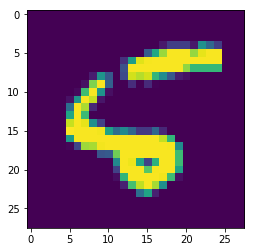

Предсказано: 5, ответ: 5


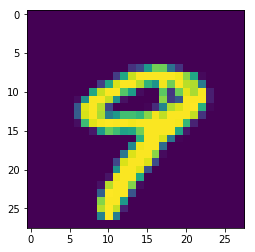

Предсказано: 9, ответ: 9


In [140]:
for i in range(10):
    plt.imshow(X_test[i])
    plt.show()
    print("Предсказано: %d, ответ: %d" % (np.where(res_onehot[i]==1)[0][0],y_test[i]))

Print here your accuracy on test set. It should be around 90%.

In [ ]:
################################################